In [8]:
import pandas as pd
import numpy as np
import os
import csv

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
def load_saved_df(df_path: str) -> pd.DataFrame:
    """
    Load a DataFrame from a CSV file.

    Parameters
    ----------
    df_path : str
        Path to the CSV file containing the DataFrame.

    Returns
    -------
    pd.DataFrame
        The loaded DataFrame.
    """
    df = pd.read_csv(df_path, index_col=False)
    str_types = ['task_id', 'parent_task_id', 'workflow_id', 'activity_id', 'agent_id', 'campaign_id', 'hostname']
    for col in str_types:
        if col in df.columns:
            df[col] = df[col].astype(str)
    dates = ['started_at', 'ended_at']
    for date in dates:
        if date in df.columns:
            df[date] = pd.to_datetime(df[date], errors='coerce')
    return df

In [5]:
BASE_DIR = '...'

In [6]:
all_csv_files = Path(BASE_DIR).glob("*.csv")
df = pd.concat((pd.read_csv(f) for f in all_csv_files), ignore_index=True)

In [7]:
def apply_mods(df):
    df['data_type_str'] =  df['data_type']
    df['data_type'] = df['data_type'].str.split('|')
    return df

In [9]:
df.to_csv(
    "combined.csv",
    index=False,                 # Don't include the index column
    quoting=csv.QUOTE_ALL,       # Quote all fields
    quotechar='"',               # Use double quotes as the quoting character
    escapechar='\\'              # Escape internal quote characters (e.g., " becomes \" inside fields)
)

In [143]:
data_types = ["DataFlow", "ControlFlow", "Scheduling", "Telemetry"]
contexts = ['Baseline', 'Baseline + FS', 'Baseline + FS + Guidelines', 'Baseline + FS + Schema', 'Baseline + FS + Schema + Values', 'Full']
model_order = ['8B', '70B', 'GEMINI', 'GPT', 'CLAUDE']
model_rename = {
    '8B': 'LLama 3-8B',
    '70B': 'LLama 3-70B',
    'GEMINI': 'Gemini',
    'GPT': 'GPT',
    'CLAUDE': 'Claude'
}

In [144]:
df = apply_mods(df)

# Overall results per model

Mean of medians

In [82]:
# Mapping for pretty model names
model_rename = {
    '8B': 'LLama 3-8B',
    '70B': 'LLama 3-70B',
    'GEMINI': 'Gemini',
    'GPT': 'GPT',
    'CLAUDE': 'Claude'
}

def compute_mean_per_model(df, judge):
    result = (
        df.loc[(df['context'] == 'Full') & (df['judge'] == judge)]
          .groupby(['query_id', 'model', 'data_type_str', 'query_type'])['L_score']
          .median()
          .reset_index(name='median_L_score')
    )
    result['data_type'] = result['data_type_str'].str.split('|')
    result = result.explode('data_type')
    return result.groupby('model')['median_L_score'].mean()

# Compute for both judges
mean_gpt = compute_mean_per_model(df, 'GPT')
mean_claude = compute_mean_per_model(df, 'CLAUDE')

# Combine into single DataFrame
mean_scores = pd.concat([mean_gpt, mean_claude], axis=1)
mean_scores.columns = ['GPT Score', 'Claude Score']
mean_scores = mean_scores.reset_index()

# Optional: rename models
mean_scores['model'] = mean_scores['model'].map(model_rename)

display(mean_scores)


         model  GPT Score  Claude Score
0  LLama 3-70B   0.898387      0.843548
1   LLama 3-8B   0.788710      0.640323
2       Claude   0.970968      0.935806
3       Gemini   0.856452      0.722581
4          GPT   0.972581      0.905806


# Plot 1: Comparing the Two Judges

/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/2086884803.py:51: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(data=plot_df, x='Model', y='Score', hue='Judge', palette=palette)
/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/2086884803.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


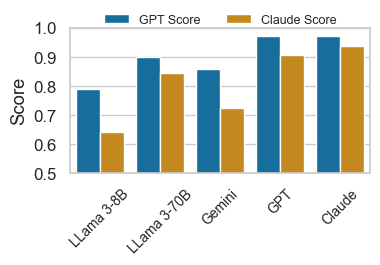

In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Settings
sns.set(style="whitegrid", font_scale=1.1)
palette = sns.color_palette("colorblind")

# Model name mapping
model_rename = {
    '8B': 'LLama 3-8B',
    '70B': 'LLama 3-70B',
    'GEMINI': 'Gemini',
    'GPT': 'GPT',
    'CLAUDE': 'Claude'
}
model_order = ['LLama 3-8B', 'LLama 3-70B', 'Gemini', 'GPT', 'Claude']

def compute_mean_per_model(df, judge):
    result = (
        df.loc[(df['context'] == 'Full') & (df['judge'] == judge)]
          .groupby(['query_id', 'model', 'data_type_str', 'query_type'])['L_score']
          .median()
          .reset_index(name='median_L_score')
    )
    result['data_type'] = result['data_type_str'].str.split('|')
    result = result.explode('data_type')
    return result.groupby('model')['median_L_score'].mean()

# Compute scores
mean_gpt = compute_mean_per_model(df, 'GPT')
mean_claude = compute_mean_per_model(df, 'CLAUDE')

# Combine into one DataFrame
mean_scores = pd.concat([mean_gpt, mean_claude], axis=1)
mean_scores.columns = ['GPT Score', 'Claude Score']
mean_scores = mean_scores.reset_index()

# Rename models
mean_scores['Model'] = mean_scores['model'].map(model_rename)

# Set custom order
mean_scores['Model'] = pd.Categorical(mean_scores['Model'], categories=model_order, ordered=True)

# Melt for plotting
plot_df = mean_scores.melt(id_vars='Model', value_vars=['GPT Score', 'Claude Score'],
                           var_name='Judge', value_name='Score')

# Plot (smaller size)
plt.figure(figsize=(4, 3))  # adjust this ratio as needed
ax = sns.barplot(data=plot_df, x='Model', y='Score', hue='Judge', palette=palette)

# Y-axis settings
ax.set_ylabel("Score")
ax.set_ylim(0.5, 1.0)
ax.set_xlabel("")
ax.set_title("")
ax.set_yticks([round(t, 1) for t in np.arange(0.5, 1.01, 0.1)])  # Y-ticks every 0.1
ax.tick_params(axis='x', labelsize=10)

# Rotate x-ticks for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Legend above plot, horizontal
ax.legend(title="", loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=2, frameon=False, fontsize=9)

plt.tight_layout()
plt.savefig("scores_per_judge.pdf", format="pdf", dpi=600, bbox_inches="tight")

# Plot 2: Comparing LLMs in Different Query Classes

/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/642531469.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(
/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/642531469.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(
/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/642531469.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(
/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/642531469.py:45: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(


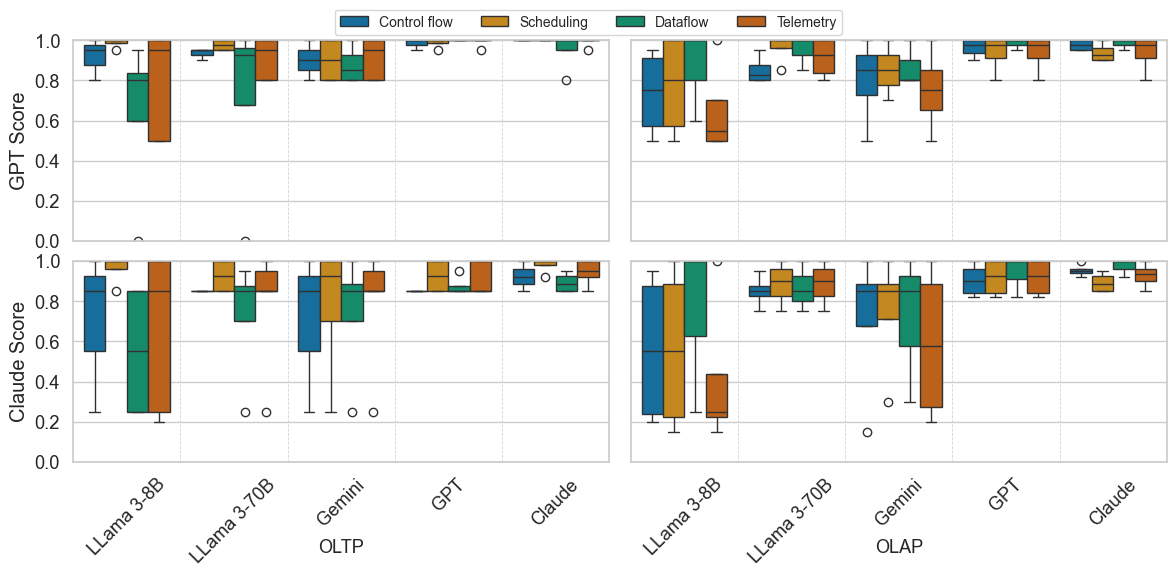

In [178]:


sns.set(style="whitegrid", font_scale=1.2)
model_rename = {
    '8B': 'LLama 3-8B',
    '70B': 'LLama 3-70B',
    'GEMINI': 'Gemini',
    'GPT': 'GPT',
    'CLAUDE': 'Claude'
}
model_order = ['8B', '70B', 'GEMINI', 'GPT', 'CLAUDE']
model_order_renamed = [model_rename[m] for m in model_order]
data_types = ["DataFlow", "ControlFlow", "Scheduling", "Telemetry"]
data_types_labels = ["Dataflow", "Control flow", "Scheduling", "Telemetry"]
data_type_rename = dict(zip(data_types, data_types_labels))
palette = sns.color_palette("colorblind")

# Preprocessing function
def prepare_result(df, judge):
    result = (
        df.loc[(df['context'] == 'Full') & (df['judge'] == judge)]
          .groupby(['query_id', 'model','data_type_str','query_type'])['L_score']
          .median()
          .reset_index(name='median_L_score')
    )
    result['data_type'] = result['data_type_str'].str.split('|')
    result = result.explode('data_type')
    result = result[result['data_type'].isin(data_types)]
    result['Data Type'] = result['data_type'].map(data_type_rename)
    result['Model'] = result['model'].map(model_rename)
    result['Model'] = pd.Categorical(result['Model'], categories=model_order_renamed, ordered=True)
    return result

# Prepare data
result_gpt = prepare_result(df, 'GPT')
result_claude = prepare_result(df, 'CLAUDE')
query_types = result_gpt['query_type'].unique()
assert len(query_types) == 2, "Expected two query types"

# Setup 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

# Plot helper
def plot_panel(data, ax, query_type, show_xticks=False, ylabel=None):
    subset = data[data['query_type'] == query_type]
    sns.boxplot(
        data=subset,
        x="Model",
        y="median_L_score",
        hue="Data Type",
        palette=palette,
        ax=ax
    )
    ax.set_ylim(0, 1.0)
    ax.set_xlabel("")  # No x-axis title
    ax.set_ylabel(ylabel if ylabel else "")
    if show_xticks:
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.set_xticklabels([])
        ax.tick_params(axis='x', length=0)

    for i in range(1, len(model_order_renamed)):
        ax.axvline(i - 0.5, color='lightgray', linestyle='--', linewidth=0.6)
    ax.axvline(len(model_order_renamed) - 0.5, color='lightgray', linestyle='--', linewidth=0.6)
    ax.set_title("")
    ax.legend_.remove()

# Plot panels
plot_panel(result_gpt, axes[0], query_types[0], show_xticks=False, ylabel="GPT Score")
plot_panel(result_gpt, axes[1], query_types[1], show_xticks=False, ylabel="")

plot_panel(result_claude, axes[2], query_types[0], show_xticks=True, ylabel="Claude Score")
plot_panel(result_claude, axes[3], query_types[1], show_xticks=True, ylabel="")

# Shared legend (top)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.975),
    ncol=4,
    frameon=True,
    fontsize=10
)

# Add OLAP / OLTP labels below the bottom row
for i, query_type in enumerate(query_types):
    ax = axes[i + 2]  # bottom row axes
    ax.annotate(
        query_type,
        xy=(0.5, -0.45),
        xycoords='axes fraction',
        ha='center',
        fontsize=13
    )

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=0.1)
plt.savefig("overall_result.pdf", format="pdf", dpi=600, bbox_inches="tight")

# Plot 3: Evaluating Impact of Contextual Information Components against Performance and Token Consumption

In [192]:
# Prepare data for both GPT and CLAUDE judges
result_gpt = prepare_result(df, 'GPT')
result_claude = prepare_result(df, 'CLAUDE')

# Add judge column to distinguish them
result_gpt['Judge'] = 'GPT'
result_claude['Judge'] = 'CLAUDE'

# Combine the two
plot_data = pd.concat([result_gpt, result_claude], ignore_index=True)

# Optional: reorder columns for clarity
plot_data = plot_data[['Judge', 'query_type', 'Model', 'Data Type', 'median_L_score']]

# Preview
print(plot_data.head())


  Judge query_type        Model     Data Type  median_L_score
0   GPT       OLTP  LLama 3-70B  Control Flow            0.95
1   GPT       OLTP  LLama 3-70B    Scheduling            0.95
2   GPT       OLTP   LLama 3-8B  Control Flow            1.00
3   GPT       OLTP   LLama 3-8B    Scheduling            1.00
4   GPT       OLTP       Claude  Control Flow            1.00


In [196]:
plot_data.to_csv('plot2.csv', index=False)

In [140]:
result = (
    df.loc[(df['judge'] == 'GPT') & (df['model'] == 'GPT')]
      .groupby(['query_id', 'context'])['L_score']
      .median()
      .reset_index(name='median_L_score')
)
result
result.groupby('context')['median_L_score'].mean()

context
Baseline                           0.0550
Baseline + FS                      0.1400
Baseline + FS + Guidelines         0.9150
Baseline + FS + Schema             0.5600
Baseline + FS + Schema + Values    0.6175
Full                               0.9675
Name: median_L_score, dtype: float64

/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/2911732531.py:57: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  ax = sns.scatterplot(


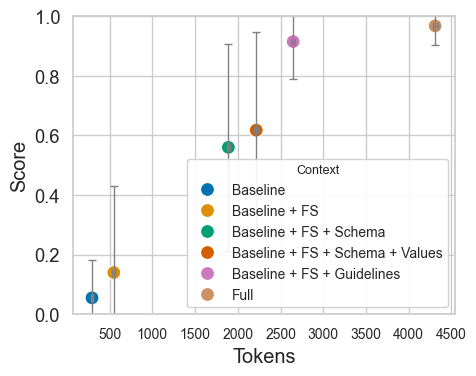

In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("colorblind")

# Custom context order
contexts = [
    'Baseline',
    'Baseline + FS',
    'Baseline + FS + Schema',
    'Baseline + FS + Schema + Values',
    'Baseline + FS + Guidelines',
    'Full'
]

# Step 1: Compute median L_score per query_id, per context
median_scores = (
    df.loc[(df['judge'] == 'GPT') & (df['model'] == 'GPT')]
    .groupby(['query_id', 'context'])['L_score']
    .median()
    .reset_index(name='median_L_score')
)

# Step 2: Compute average tokens per query_id, per context
avg_tokens = (
    df.loc[(df['judge'] == 'GPT') & (df['model'] == 'GPT')]
    .groupby(['query_id', 'context'])['overall_tokens']
    .mean()
    .reset_index(name='avg_tokens')
)

# Step 3: Merge
merged = pd.merge(median_scores, avg_tokens, on=['query_id', 'context'])

# Step 4: Compute mean + std per context
summary = (
    merged.groupby('context')
    .agg(
        avg_score=('median_L_score', 'mean'),
        std_score=('median_L_score', 'std'),
        avg_tokens=('avg_tokens', 'mean'),
        std_tokens=('avg_tokens', 'std')
    )
    .reset_index()
)

# Enforce context order
summary['context'] = pd.Categorical(summary['context'], categories=contexts, ordered=True)
summary = summary.sort_values('context')

# Step 5: Plot
plt.figure(figsize=(5, 4))
ax = sns.scatterplot(
    data=summary,
    x='avg_tokens',
    y='avg_score',
    hue='context',
    palette=palette,
    s=100,
    legend='full'
)

# Error bars
plt.errorbar(
    summary['avg_tokens'],
    summary['avg_score'],
    xerr=summary['std_tokens'],
    yerr=summary['std_score'],
    fmt='none',
    ecolor='gray',
    elinewidth=1,
    capsize=3
)

# Axis labels
ax.set_xlabel("Tokens")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.tick_params(axis='x', labelsize=10)

# Legend inside the plot
legend = ax.legend(
    title="Context",
    loc='lower right',
    fontsize=10,
    title_fontsize=9,
    frameon=True
)
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig("context_vs_score_tokens.pdf", format="pdf", dpi=600, bbox_inches="tight")

In [197]:
plot_df = summary.copy()

# Optional: rearrange columns for clarity
plot_df = plot_df[[
    'context',
    'avg_tokens',
    'std_tokens',
    'avg_score',
    'std_score'
]]

# Display or export
plot_df.to_csv('plot3.csv', index=False)
display(plot_df)

                           context   avg_tokens  std_tokens  avg_score  \
0                         Baseline   293.050000   16.554809     0.0550   
1                    Baseline + FS   548.433333   16.692997     0.1400   
3           Baseline + FS + Schema  1889.050000   17.503308     0.5600   
4  Baseline + FS + Schema + Values  2215.116667   20.811680     0.6175   
2       Baseline + FS + Guidelines  2646.933333   26.266649     0.9150   
5                             Full  4308.483333   28.988297     0.9675   

   std_score  
0   0.127630  
1   0.289100  
3   0.346638  
4   0.330181  
2   0.126803  
5   0.063401  


,context,avg_tokens,std_tokens,avg_score,std_score
0,Baseline,293.050000,16.554809,0.0550,0.127630
1,Baseline + FS,548.433333,16.692997,0.1400,0.289100
3,Baseline + FS + Schema,1889.050000,17.503308,0.5600,0.346638
4,Baseline + FS + Schema + Values,2215.116667,20.811680,0.6175,0.330181
2,Baseline + FS + Guidelines,2646.933333,26.266649,0.9150,0.126803
5,Full,4308.483333,28.988297,0.9675,0.063401


# Plot 4: Evaluating Impact of Contextual Information Components on Different Data Types

/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/80297035.py:49: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(
/var/folders/jx/23j21rtx1czb2tpqht16pz907m8f48/T/ipykernel_39920/80297035.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


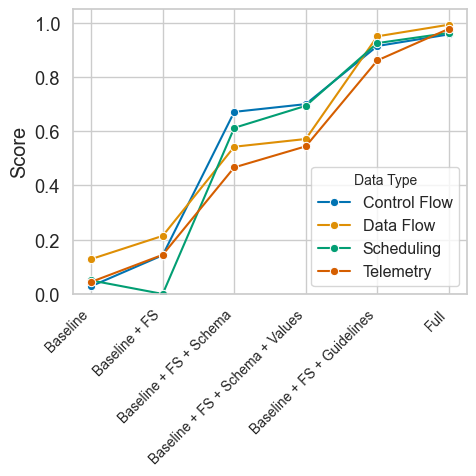

In [200]:


# Set plot style
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("colorblind")

# Define context and data_type order
contexts = [
    'Baseline',
    'Baseline + FS',
    'Baseline + FS + Schema',
    'Baseline + FS + Schema + Values',
    'Baseline + FS + Guidelines',
    'Full'
]
data_types = ["DataFlow", "ControlFlow", "Scheduling", "Telemetry"]
data_types_labels = ["Data Flow", "Control Flow", "Scheduling", "Telemetry"]
data_type_rename = dict(zip(data_types, data_types_labels))

# Step 1: Filter GPT model and GPT judge
df_filtered = df[(df['judge'] == 'GPT') & (df['model'] == 'GPT')].copy()

# Step 2: Explode data_type field
df_filtered['data_type'] = df_filtered['data_type_str'].str.split('|')
df_exploded = df_filtered.explode('data_type')
df_exploded = df_exploded[df_exploded['data_type'].isin(data_types)]
df_exploded['Data Type'] = df_exploded['data_type'].map(data_type_rename)

# Step 3: Compute median score per query_id, context, and data_type
grouped = (
    df_exploded
    .groupby(['query_id', 'context', 'Data Type'])['L_score']
    .median()
    .reset_index(name='median_L_score')
)

# Step 4: Compute mean and std of the medians, grouped by context and Data Type
summary = (
    grouped
    .groupby(['context', 'Data Type'])['median_L_score']
    .agg(avg_score='mean', std_score='std')
    .reset_index()
)

# Ensure consistent order
summary['context'] = pd.Categorical(summary['context'], categories=contexts, ordered=True)
summary = summary.sort_values(['Data Type', 'context'])

# Step 5: Plot
plt.figure(figsize=(5, 5))
ax = sns.lineplot(
    data=summary,
    x='context',
    y='avg_score',
    hue='Data Type',
    palette=palette,
    marker='o',
    linewidth=1.5
)

# Add error bars
for _, row in summary.iterrows():
    ax.errorbar(
        x=row['context'],
        y=row['avg_score'],
        #yerr=row['std_score'],
        fmt='none',
        #ecolor='gray',
        #elinewidth=0.1,
        capsize=3
    )

# Style the plot
ax.set_ylabel("Score")
ax.set_xlabel("")
ax.set_ylim(0, 1.05)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(axis='x', labelsize=10)

legend = ax.legend(
    title="Data Type",
    loc='lower right',
    fontsize=11.5,
    title_fontsize=10,
    frameon=True
)

plt.tight_layout()
plt.savefig("context_vs_data_types.pdf", format="pdf", dpi=600, bbox_inches="tight")

In [201]:
plot_df = summary.copy()

# Optional: reorder columns for clarity
plot_df = plot_df[['context', 'Data Type', 'avg_score', 'std_score']]

# Preview the DataFrame
display(plot_df)
plot_df.to_csv('plot4.csv', index=False)

,context,Data Type,avg_score,std_score
0,Baseline,Control Flow,0.028571,0.075593
4,Baseline + FS,Control Flow,0.142857,0.377964
12,Baseline + FS + Schema,Control Flow,0.671429,0.401930
16,Baseline + FS + Schema + Values,Control Flow,0.700000,0.354730
8,Baseline + FS + Guidelines,Control Flow,0.914286,0.094491
20,Full,Control Flow,0.957143,0.073193
1,Baseline,Data Flow,0.128571,0.188982
5,Baseline + FS,Data Flow,0.214286,0.393398
13,Baseline + FS + Schema,Data Flow,0.542857,0.355233
17,Baseline + FS + Schema + Values,Data Flow,0.571429,0.314718


# 5. Response Time

In [207]:
# Step 1: Filter for GPT judge
df_gpt = df[df['judge'] == 'GPT'].copy()

# Step 2: Explode the data_type field
df_gpt['data_type'] = df_gpt['data_type_str'].str.split('|')
df_exploded = df_gpt.explode('data_type')

# Optional: drop rows with missing or empty data_type
df_exploded = df_exploded[df_exploded['data_type'].notna() & (df_exploded['data_type'] != '')]

# Step 3: Compute median time per query_id, model, query_type, data_type
medians = (
    df_exploded
    .groupby(['query_id', 'query_type', 'model', 'data_type'])['time_taken_seconds']
    .median()
    .reset_index(name='median_time')
)

# Step 4: Compute mean of medians per query_type, model, data_type
mean_of_medians = (
    medians
    .groupby(['query_type', 'model', 'data_type'])['median_time']
    .mean()
    .reset_index(name='mean_of_median_time')
)

# Display or export
display(mean_of_medians)


,query_type,model,data_type,mean_of_median_time
0,OLAP,70B,ControlFlow,1.991775
1,OLAP,70B,DataFlow,2.006333
2,OLAP,70B,Scheduling,1.995725
3,OLAP,70B,Telemetry,2.070475
4,OLAP,8B,ControlFlow,0.729450
5,OLAP,8B,DataFlow,0.725033
6,OLAP,8B,Scheduling,0.758925
7,OLAP,8B,Telemetry,0.786975
8,OLAP,CLAUDE,ControlFlow,3.234900
9,OLAP,CLAUDE,DataFlow,3.338967


In [208]:
mean_of_medians['mean_of_median_time'].mean()

np.float64(1.7173860208333334)